# **V6 on Synthetic Datatest**

In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from utils.wrapper import YOLOAPIWrappper
from utils.pipeline import CPPipeline

### **Multiplicative**

In [2]:
v6 = "../utils/v6/bestv6.onnx"
yolov6_detector_synth = YOLOAPIWrappper(v6,file_path='../calibration/calibv6_synth_m.pickle', conf_thres=0.7, iou_thres=0.5)
pipev6_synth = CPPipeline(yolov6_detector_synth, test_set='test_synth', method='multiplicative')

In [3]:
X_train, y_train, labels_train= pipev6_synth.extract_yolo_dataset()
X_train, X_val, y_train, y_val, labels_train, labels_val = pipev6_synth.calibration_and_val(X_train, y_train, labels_train)
conformal_predictor= pipev6_synth.pipeline( X_train=X_train, y_train= y_train, labels_train= labels_train)

Predictions: [[1348.74682617 1237.56884766 1620.20532227 1438.43652344]
 [ 881.45123291  982.50598145 1115.69140625 1166.31774902]
 [ 649.581604   1249.57531738  707.28326416 1320.94055176]
 ...
 [ 591.09454346 1044.23034668  842.81427002 1174.17077637]
 [ 639.09924316 1092.83789062  812.71435547 1227.86474609]
 [1568.109375   1080.36865234 1812.66870117 1246.15869141]]
Matched Ground Truths: [[1339. 1240. 1610. 1440.]
 [ 879.  985. 1118. 1164.]
 [ 650. 1254.  708. 1322.]
 ...
 [ 593. 1044.  846. 1172.]
 [ 640. 1095.  811. 1227.]
 [1567. 1086. 1809. 1243.]]
Images: ['/home/aws_install/data/yolo_database/images/test_synth/WSSS_02L_35_23.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/LEMD_32R_35_21.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/RJAA_34R_35_05.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/MDSD_17_35_28.jpeg', '/home/aws_install/data/yolo_database/images/test_synth/LFRS_21_35_05.jpeg', '/home/aws_install/data/yolo_database/i

Predictions: (array([[1502.8394, 1285.0844, 1675.2842, 1492.3949]], dtype=float32), array([0.95020294], dtype=float32))
Marginal coverage: 1.0
Average area: 43669.03125
Confidence score : [0.95020294]


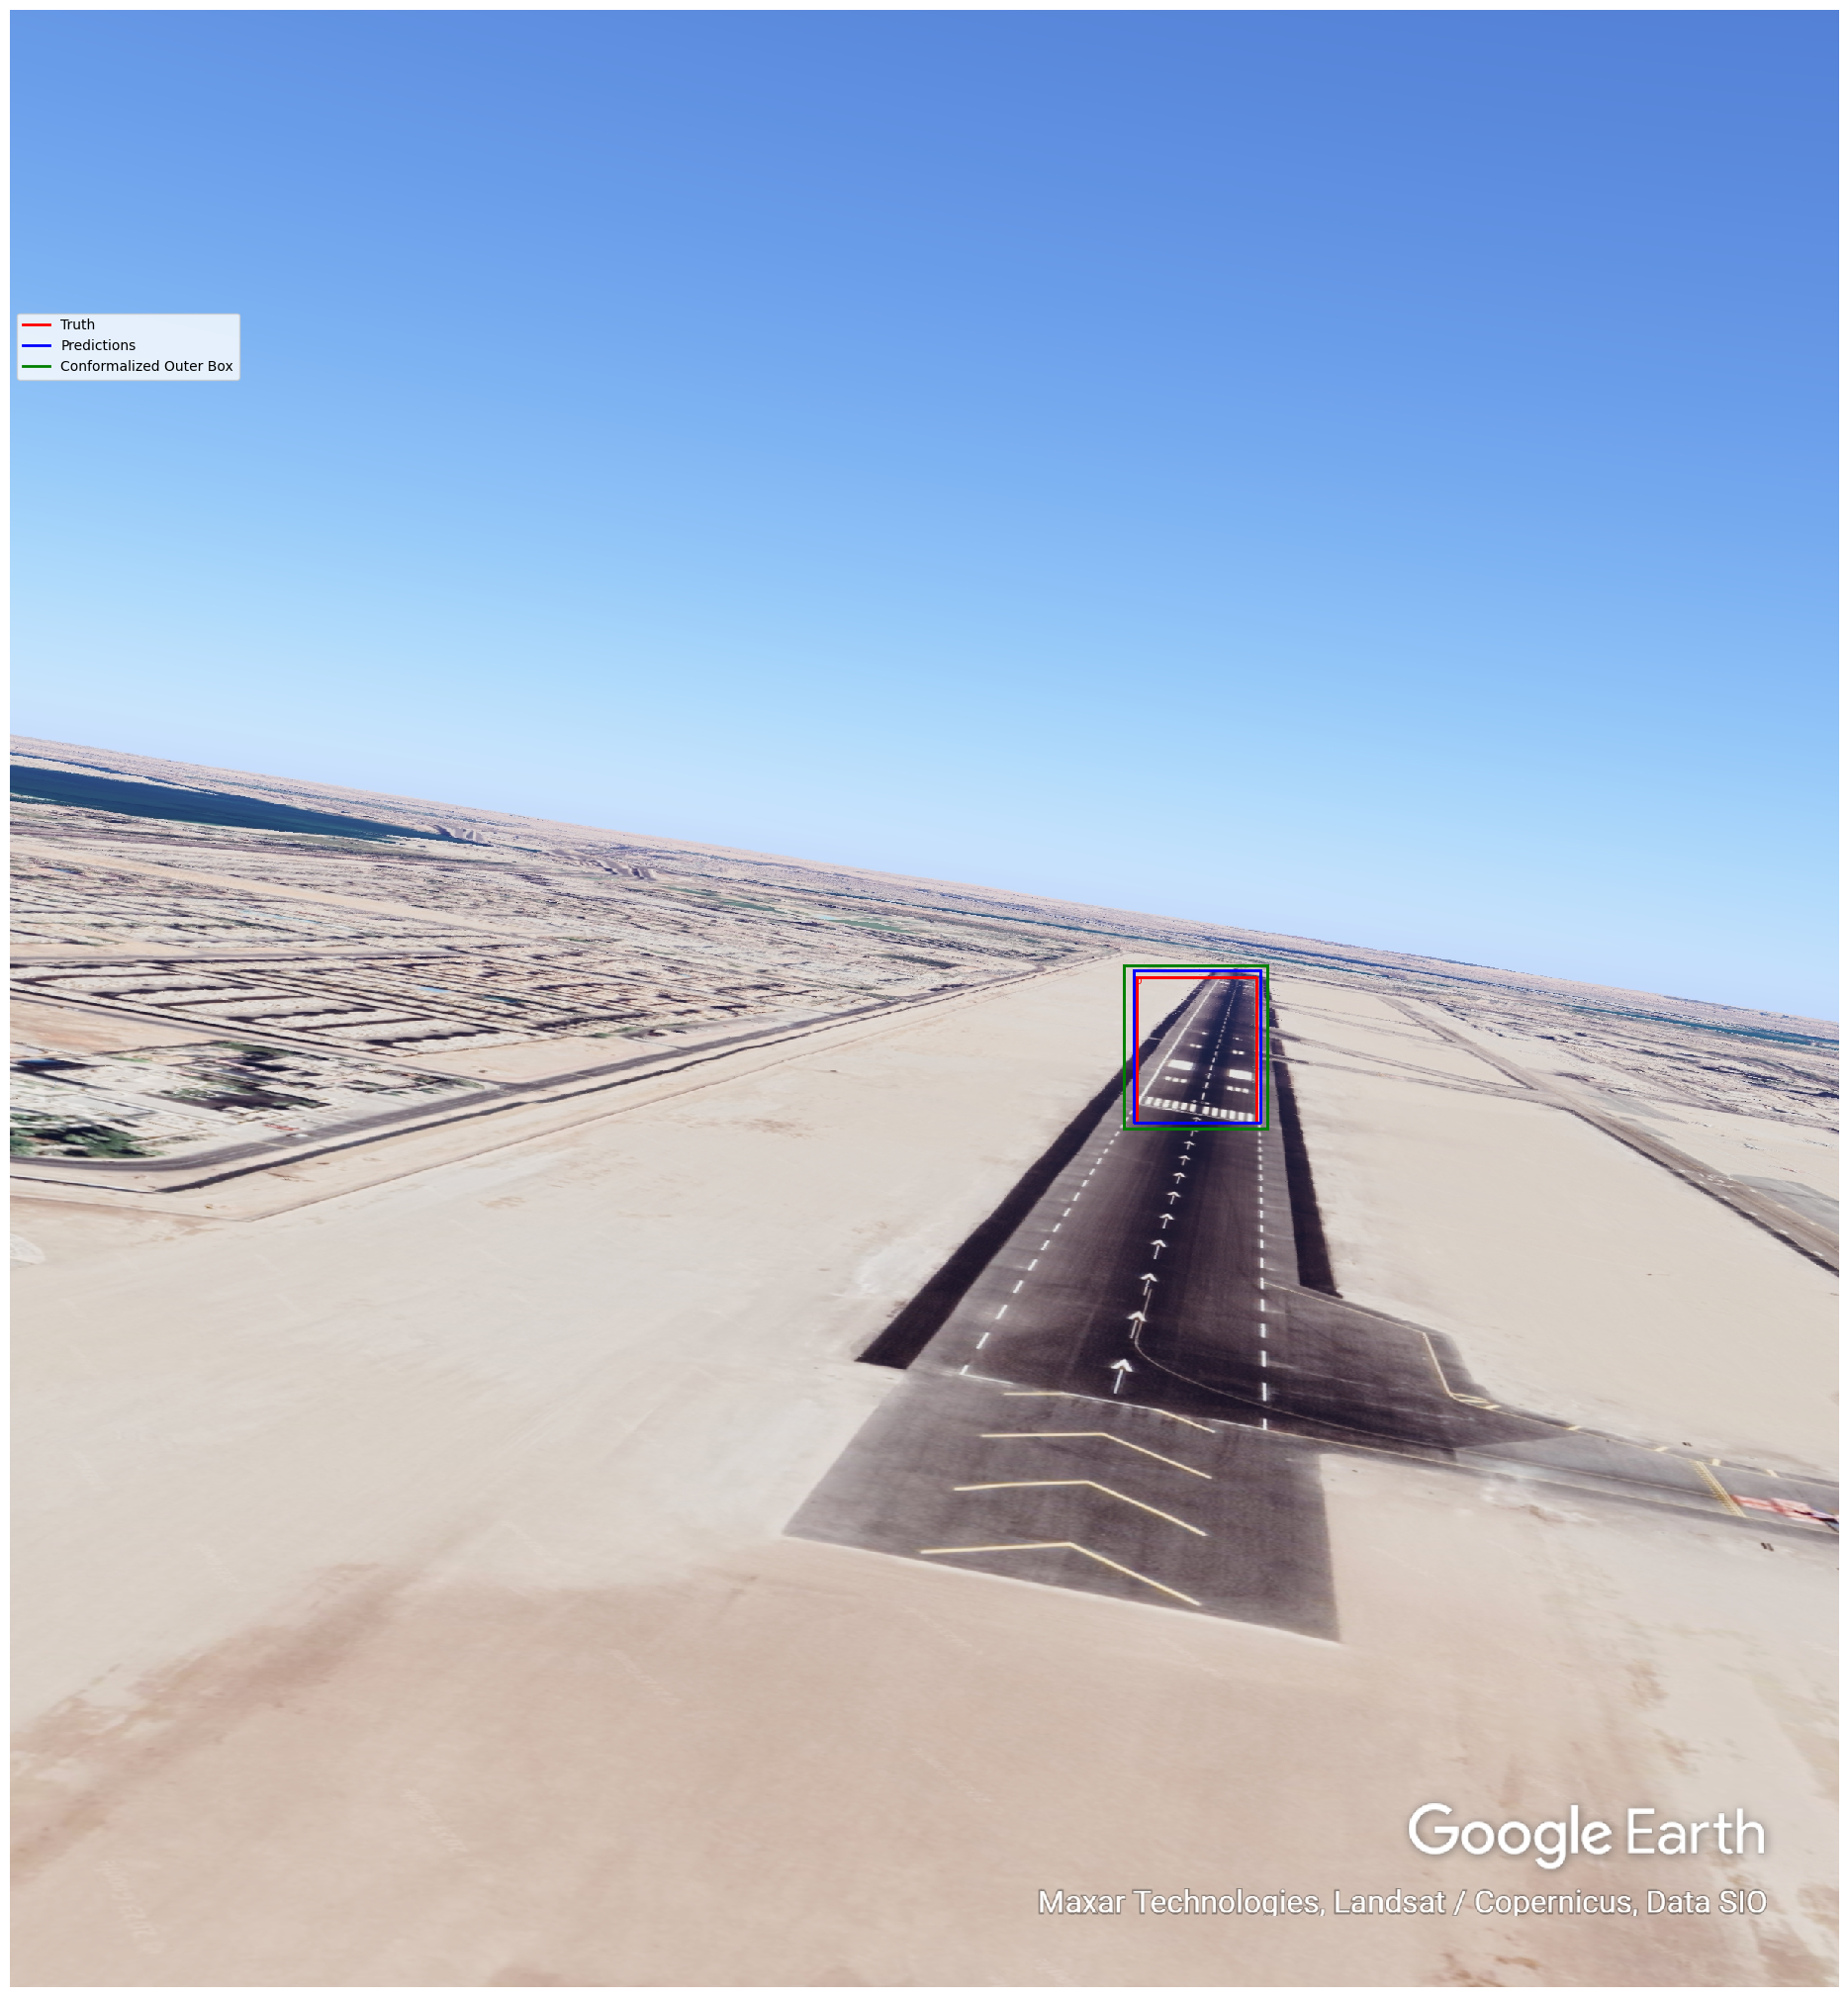

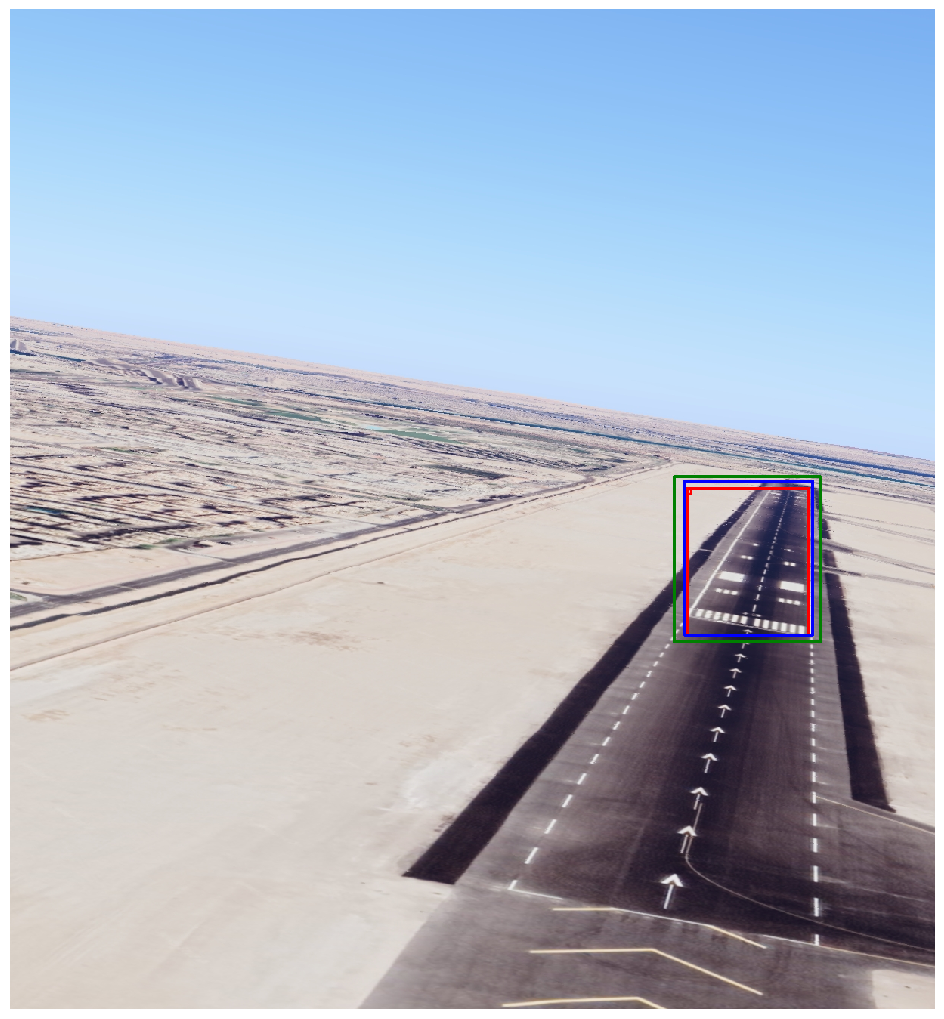

In [4]:
pipev6_synth.infer_eval_single_image(
    conformal_predictor, 
    X_val[5],  # Image path at index 5
    y_val[5],  # Ground truth bounding boxes at index 5
    labels_val[5],  # Labels at index 5
    None  
)

In [5]:
y_pred_val, y_true_val, images_val, classes_val,score_val, box_inner_val, box_outer_val = pipev6_synth.infer_all_images(conformal_predictor,X_val, y_val, labels_val, visualize = False)

Number of images: 443
Number of images without predictions: 18
Number of images with predictions: 425


In [6]:
average_glo_area, cover = pipev6_synth.average_cover_and_area(y_pred_val, y_true_val, box_outer_val)

Average area of prediction intervals: 87277.8046875
Average length of prediction intervals: 295.42816162109375
Average Marginal coverage: 0.7435294117647059


In [7]:
import os
import pandas as pd
from utils.helpers import iou, ioa

filenames = []
all_preds = []
all_trues = []
all_classes = []
iou_pred_c_gt = []
ioa_pred_c_gt = []
iou_pred_gt = []
ioa_pred_gt = []
score = []
box_inner = []
box_outer = []
all_cover = []
glo_area = []


for y_pred_, y_true_, img_path_, clss_, score_, box_inner_, box_outer_, cover_, avg_area_ in zip(y_pred_val, y_true_val, X_val, classes_val, score_val, box_inner_val, box_outer_val, cover, average_glo_area):


    filenames.append(os.path.basename(img_path_))
    all_preds.append(y_pred_)
    all_trues.append(y_true_)
    all_classes.append(clss_)
    iou_pred_c_gt.append(iou(box_outer_.flatten(), y_true_.flatten())) # iou between outer box and gt
    ioa_pred_c_gt.append(ioa(box_outer_.flatten(), y_true_.flatten())) # ioa between outer box and gt
    iou_pred_gt.append(iou(y_pred_.flatten(), y_true_.flatten()))   # iou between yolo pred and gt
    ioa_pred_gt.append(ioa(y_pred_.flatten(), y_true_.flatten()))  # ioa between yolo pred and gt
    score.append(score_) # confidence score
    box_inner.append(box_inner_)
    box_outer.append(box_outer_)
    all_cover.append(cover_) #cover between conformal box and gt
    glo_area.append(avg_area_)

df = pd.DataFrame({
    'filename': filenames,
    'pred_yolo': all_preds,
    'gt': all_trues,
    'class': all_classes,
    'iou_pred_c_gt': iou_pred_c_gt,
    'ioa_pred_c_gt': ioa_pred_c_gt,
    'iou_pred_gt': iou_pred_gt,
    'ioa_pred_gt': ioa_pred_gt,
    'score': score,
    'box_inner': box_inner,
    'box_outer': box_outer,
    'cover': cover,
    'avg_area': glo_area
})

all = pd.read_csv("/home/aws_install/conformal_runway_detection/surrogate/all_test_with_real.csv")

all_subset = all[['filename', 'slant_distance', 'time_to_landing']]

df = pd.merge(df, all_subset, on='filename', how='left')

df.to_csv('results_v6_synth_m.csv', index=False)